In [72]:
import pandas as pd

# Cargar archivos
cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")
estrategias = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroEmisora.csv")
respuestas = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatRespuestaBancos.csv")

# Enriquecer con estrategia usada
cobros = cobros.merge(estrategias, on="idListaCobro", how="left")

# Enriquecer con descripción de respuesta del banco
cobros = cobros.merge(respuestas, left_on="idRespuestaBanco", right_on="IdRespuestaBanco", how="left")

# Marcar si fue exitoso
cobros["esExitoso"] = cobros["montoCobrado"] > 0

# Clasificar respuesta en categorías generales
def clasificar_respuesta(row):
    if row["idRespuestaBanco"] == "00":
        return "exitosa"
    elif row["Descripcion"] in ["Cuenta Cancelada", "Cuenta Bloqueada", "Cuenta Inexistente"]:
        return "cuenta_invalida"
    elif row["montoCobrado"] > 0:
        return "parcial"
    else:
        return "otros"

cobros["respuestaCategoria"] = cobros.apply(clasificar_respuesta, axis=1)

# Sort por esExitoso True 
cobros = cobros.sort_values(by=["esExitoso", "idListaCobro", "idRespuestaBanco"], ascending=[False, True, True])

cobros.head()


/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_2119/2427794397.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  cobros = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/ListaCobroDetalleUnido.csv")


,idListaCobro,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,idEmisora,IdRespuestaBanco,Descripcion,esExitoso,respuestaCategoria
52431,79678,291172,23794381,44,275.50,275.50,275.50,04/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52327,80111,459208,23840286,21,720.36,720.36,720.36,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52340,80111,495309,23840297,21,225.87,225.87,225.87,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52345,80111,507710,23840301,21,833.37,833.37,833.37,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa
52353,80111,525580,23840309,21,483.91,483.91,483.91,11/01/2022,00,20,00,Domiciliacion Exitosa,True,exitosa


In [73]:
print(cobros.shape)
# Drop columnas innecesarias: idListaCobro, fechaCobroBanco, IdRespuestaBanco
cobros.drop(columns=["idListaCobro", "fechaCobroBanco", "IdRespuestaBanco"], inplace=True)
# Drop NaN values
cobros.dropna(subset=["idRespuestaBanco"], inplace=True)
print(cobros.shape)

(10057440, 14)
(9907879, 11)


In [74]:
#  mostrar valores unicos en idEmisora
print(cobros["idEmisora"].unique())

[20 19 68 78 25 21 23 24 34  1 36 51 79 62 75 10  2 13  9 12 17  5  6 15
 22 18 14 16 45  4 11  3  7]


In [75]:
# Cargar tabla de costos por estrategia
costos = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatEmisora.csv")

# Asegurarse de que los nombres de columnas están bien
costos.columns = costos.columns.str.strip()  # quitar espacios accidentales
costos["cobraSoloExitoso"] = costos["cobraSoloExitoso"].astype(bool)

# Unir al dataframe de cobros por 'idEmisora'
cobros = cobros.merge(costos[["idEmisora", "costo", "cobraSoloExitoso"]], on="idEmisora", how="left")

# Calcular el costo real de cada intento según si se cobra solo por éxito o siempre
def calcular_costo_transaccion(row):
    if row["cobraSoloExitoso"]:
        return row["costo"] if row["esExitoso"] else 0
    else:
        return row["costo"]

cobros["costoTransaccion"] = cobros.apply(calcular_costo_transaccion, axis=1)

cobros_exitosos = cobros[cobros["esExitoso"]].groupby("idEmisora").size().reset_index(name="cantidadExitosos")
print(cobros_exitosos)

# Drop todos los idEmisora que tengan menos de 50 esExitoso True
# Calcular el total de éxitos por estrategia
exitos_por_estr = cobros.groupby("idEmisora")["esExitoso"].sum()

# Identificar idEmisora con al menos 50 éxitos
estr_validas = exitos_por_estr[exitos_por_estr >= 500].index

# Filtrar el DataFrame eliminando las estrategias con menos de 50 éxitos
cobros_filtrado = cobros[cobros["idEmisora"].isin(estr_validas)].copy()



    idEmisora  cantidadExitosos
0           1             15839
1           2              1734
2           5             39254
3           6             19203
4           9             48489
5          10             14650
6          12             17380
7          13              1980
8          14                 6
9          15               349
10         16                81
11         17             53967
12         18              2502
13         19              1551
14         20              1735
15         21             32294
16         22              2003
17         23              4529
18         24               496
19         25              8836
20         34              1218
21         36              5261
22         51               145
23         62              1201
24         68              8414
25         75               187
26         78                21
27         79             10584


In [76]:
cobros = cobros_filtrado.copy()
# Cantidad de cobros exitosos en idEmisora == 1
cobros_exitosos = cobros[cobros["esExitoso"]].groupby("idEmisora").size().reset_index(name="cantidadExitosos")
print(cobros_exitosos)

    idEmisora  cantidadExitosos
0           1             15839
1           2              1734
2           5             39254
3           6             19203
4           9             48489
5          10             14650
6          12             17380
7          13              1980
8          17             53967
9          18              2502
10         19              1551
11         20              1735
12         21             32294
13         22              2003
14         23              4529
15         25              8836
16         34              1218
17         36              5261
18         62              1201
19         68              8414
20         79             10584


In [77]:
# Ordenar por crédito y consecutivoCobro
cobros = cobros.sort_values(by=["idCredito", "consecutivoCobro"])

# Calcular número de intento por crédito
cobros["num_intento"] = cobros.groupby("idCredito").cumcount() + 1
cobros["es_segundo_intento"] = cobros["num_intento"] == 2
cobros["num_exitos_previos"] = cobros.groupby("idCredito")["esExitoso"].cumsum() - cobros["esExitoso"].astype(int)
cobros["num_intentos_previos"] = cobros["num_intento"] - 1

cobros.head()

,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,idRespuestaBanco,idEmisora,Descripcion,esExitoso,respuestaCategoria,costo,cobraSoloExitoso,costoTransaccion,num_intento,es_segundo_intento,num_exitos_previos,num_intentos_previos
1426581,6,32697369,2,375.47,375.47,0.0,4.0,23,NaN,False,otros,1.91,True,0.0,1,False,0,0
4188990,3674,36776754,72,344.18,344.18,0.0,1.0,12,NaN,False,otros,2.50,False,2.5,1,False,0,0
314593,4635,27248919,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,1,False,0,0
328303,4635,29393671,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,2,True,0,1
388055,4635,29600474,72,160.13,160.13,0.0,04,25,Cuenta Insuficiencia Fondos,False,otros,6.00,True,0.0,3,False,0,2


In [78]:
# Proporcion de intentos exitosos segun columna esExitoso 
exitosos = cobros[cobros["esExitoso"] == True]
fallidos = cobros[cobros["esExitoso"] == False]
print("Proporción de intentos exitosos:", len(exitosos) / (len(exitosos) + len(fallidos)))



Proporción de intentos exitosos: 0.02962948562328399


In [79]:
cobros.groupby("idEmisora")["esExitoso"].agg(["count", "sum"]).assign(tasa=lambda df: df["sum"] / df["count"]).sort_values("sum", ascending=False)

# # drop columnas con idEmisora 23 y 36
# cobros.drop(cobros[cobros["idEmisora"].isin([23, 36])].index, inplace=True)

,count,sum,tasa
idEmisora,,,
17,222739,53967,0.242288
9,125829,48489,0.385356
5,2227362,39254,0.017624
21,1327258,32294,0.024331
6,3316858,19203,0.005790
12,160604,17380,0.108216
1,654165,15839,0.024213
10,249965,14650,0.058608
79,61892,10584,0.171008


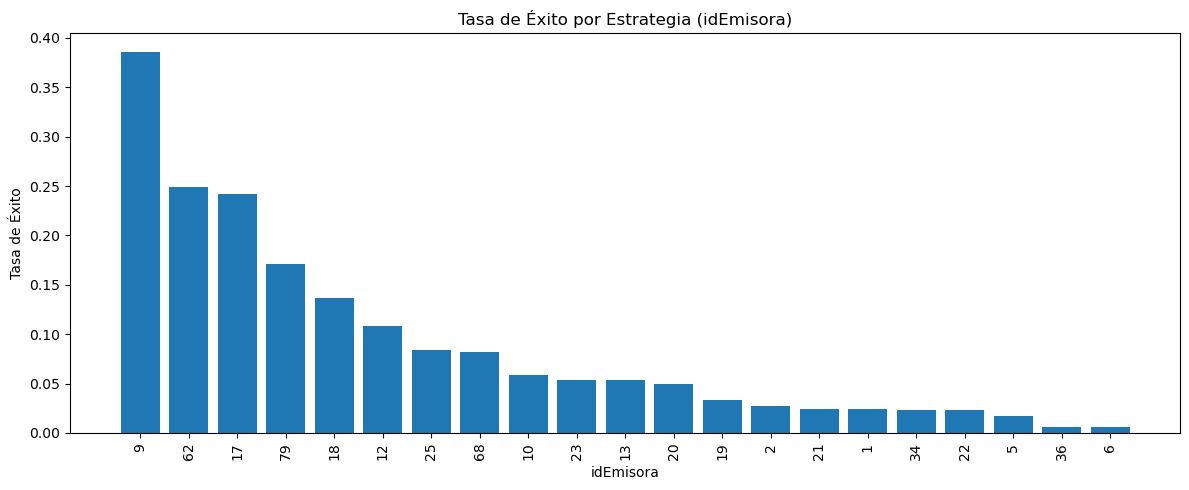

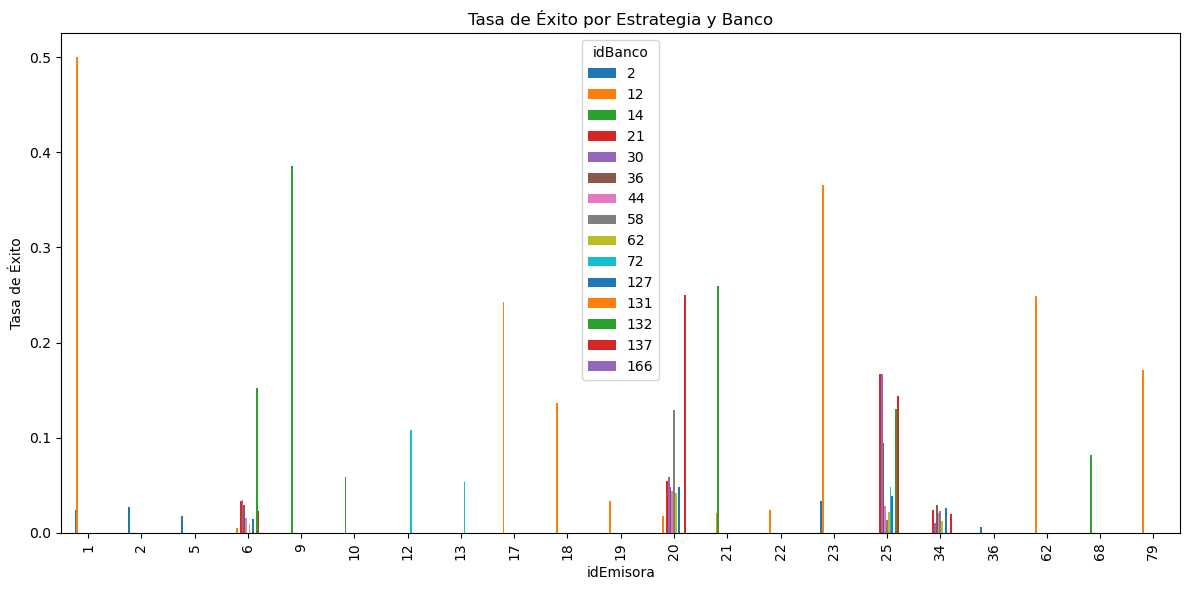

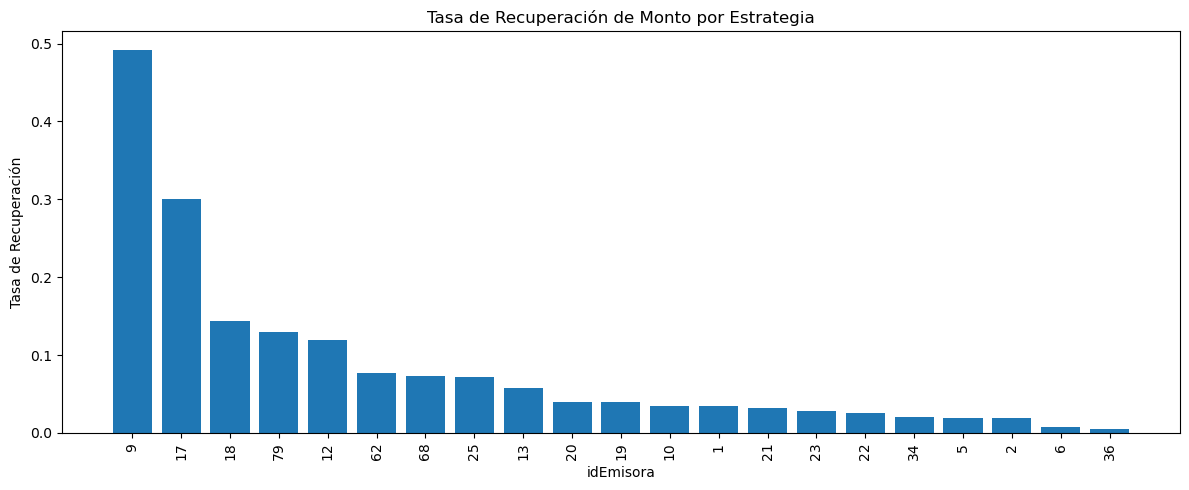

Tasa de éxito en el segundo intento: 18.10%

Distribución de respuestas del banco en segundo intento:
respuestaCategoria
otros              0.806341
parcial            0.141857
exitosa            0.039155
cuenta_invalida    0.012647
Name: proportion, dtype: float64


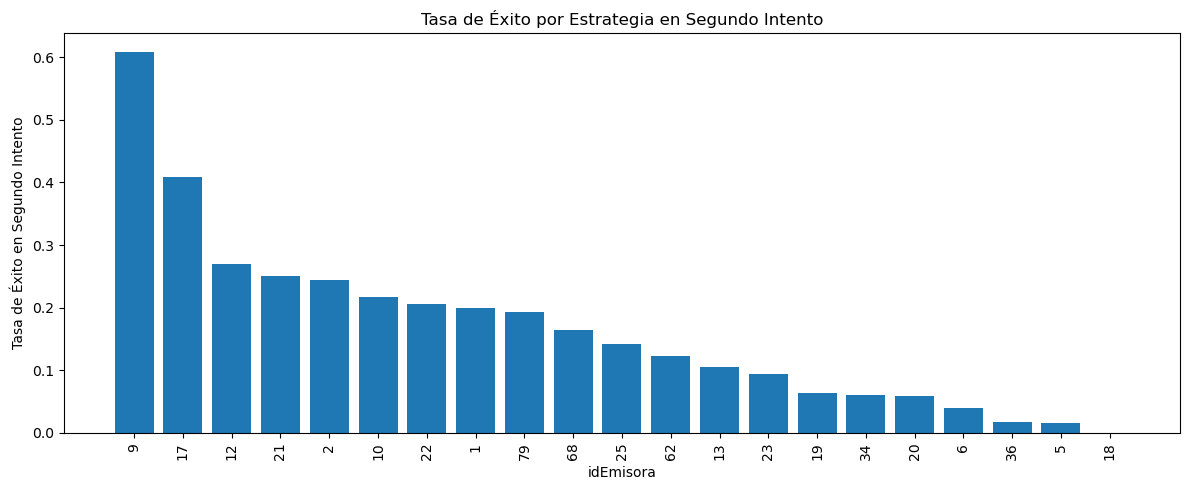

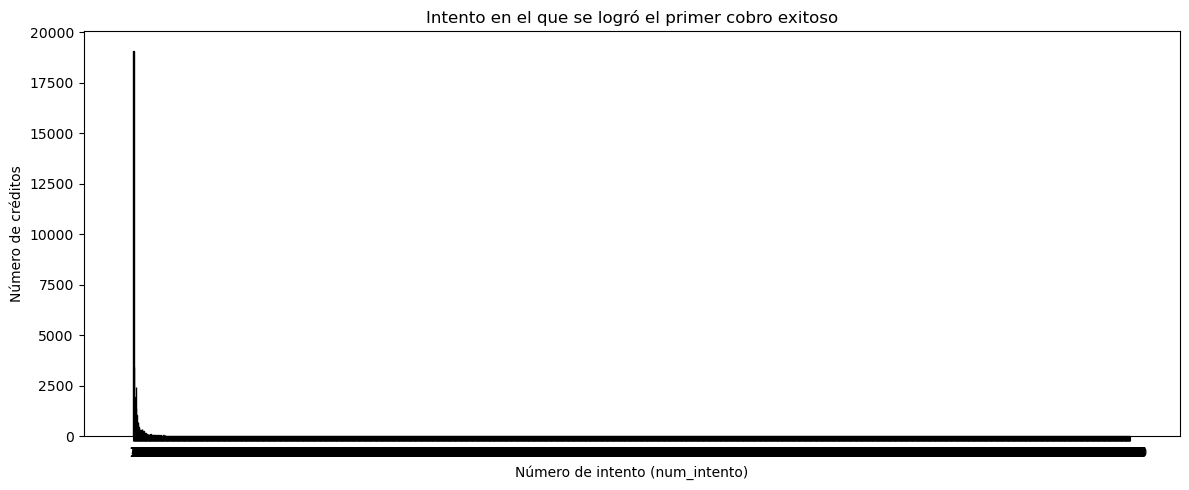

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que `cobros` esté cargado y contenga estas columnas:
# idEmisora, idBanco, montoExigible, montoCobrado, esExitoso

# === 1. Tasa de Éxito por Estrategia (idEmisora) ===
exito_por_estrategia = cobros.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
exito_por_estrategia["tasa_exito"] = exito_por_estrategia["sum"] / exito_por_estrategia["count"]
exito_por_estrategia = exito_por_estrategia.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(exito_por_estrategia.index.astype(str), exito_por_estrategia["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia (idEmisora)")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === 2. Tasa de Éxito por Banco y Estrategia ===
exito_banco_estrategia = cobros.groupby(["idBanco", "idEmisora"])["esExitoso"].agg(["count", "sum"])
exito_banco_estrategia["tasa_exito"] = exito_banco_estrategia["sum"] / exito_banco_estrategia["count"]
pivot_be = exito_banco_estrategia.reset_index().pivot(index="idEmisora", columns="idBanco", values="tasa_exito")

pivot_be.plot(kind="bar", figsize=(12, 6))
plt.title("Tasa de Éxito por Estrategia y Banco")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito")
plt.xticks(rotation=90)
plt.legend(title="idBanco")
plt.tight_layout()
plt.show()

# === 3. Tasa de Recuperación de Monto por Estrategia ===
monto_estrategia = cobros.groupby("idEmisora")[["montoExigible", "montoCobrado"]].sum()
monto_estrategia["tasa_recuperacion"] = monto_estrategia["montoCobrado"] / monto_estrategia["montoExigible"]
monto_estrategia = monto_estrategia.sort_values("tasa_recuperacion", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(monto_estrategia.index.astype(str), monto_estrategia["tasa_recuperacion"])
plt.title("Tasa de Recuperación de Monto por Estrategia")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Recuperación")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# %%
# === 4. Análisis de SEGUNDO intento de cobranza ===
segundos = cobros[cobros["es_segundo_intento"] == True]

# Tasa de éxito en el segundo intento
tasa_exito_segundo = segundos["esExitoso"].mean()
print(f"Tasa de éxito en el segundo intento: {tasa_exito_segundo:.2%}")

# Distribución de respuestas en segundo intento
print("\nDistribución de respuestas del banco en segundo intento:")
print(segundos["respuestaCategoria"].value_counts(normalize=True))

# Comparar estrategias más comunes en segundo intento
estrategias_segundo = segundos.groupby("idEmisora")["esExitoso"].agg(["count", "sum"])
estrategias_segundo["tasa_exito"] = estrategias_segundo["sum"] / estrategias_segundo["count"]
estrategias_segundo = estrategias_segundo.sort_values("tasa_exito", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(estrategias_segundo.index.astype(str), estrategias_segundo["tasa_exito"])
plt.title("Tasa de Éxito por Estrategia en Segundo Intento")
plt.xlabel("idEmisora")
plt.ylabel("Tasa de Éxito en Segundo Intento")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# %%
# === 5. Análisis de intentos acumulados antes de éxito ===
# Solo intentos exitosos
exitos = cobros[cobros["esExitoso"] == True]

# Para cada crédito exitoso, ¿en qué intento lo logró?
primer_exito = exitos.groupby("idCredito")["num_intento"].min()

plt.figure(figsize=(12, 5))
plt.hist(primer_exito, bins=range(1, primer_exito.max()+2), edgecolor='black')
plt.title("Intento en el que se logró el primer cobro exitoso")
plt.xlabel("Número de intento (num_intento)")
plt.ylabel("Número de créditos")
plt.xticks(range(1, primer_exito.max()+1))
plt.tight_layout()
plt.show()


In [81]:
# Verifica si alguna estrategia exitosa tiene costo == 0
cobros[(cobros["montoCobrado"] > 0) & (cobros["costoTransaccion"] == 0)][["idEmisora", "esExitoso", "costo", "montoCobrado","cobraSoloExitoso"]].value_counts()


Series([], Name: count, dtype: int64)

In [82]:
# %%
# Agrupar métricas por estrategia
estrategias_eval = cobros.groupby("idEmisora").agg(
    total_intentos=("idCredito", "count"),
    total_exitos=("esExitoso", "sum"),
    monto_total_cobrado=("montoCobrado", "sum"),
    costo_total=("costoTransaccion", "sum")
)

# Métricas adicionales
estrategias_eval["tasa_exito"] = estrategias_eval["total_exitos"] / estrategias_eval["total_intentos"]
estrategias_eval["roi"] = estrategias_eval["monto_total_cobrado"] / estrategias_eval["costo_total"]
estrategias_eval["efectividad_ajustada"] = (estrategias_eval["monto_total_cobrado"] - estrategias_eval["costo_total"]) / estrategias_eval["total_intentos"]

estrategias_eval = estrategias_eval.sort_values("efectividad_ajustada", ascending=False)
estrategias_eval.reset_index(inplace=True)

# Mostrar top 10 estrategias
estrategias_eval.head(50)


,idEmisora,total_intentos,total_exitos,monto_total_cobrado,costo_total,tasa_exito,roi,efectividad_ajustada
0,9,125829,48489,37746119.43,354837.78,0.385356,106.375706,297.159491
1,17,222739,53967,46906100.02,431736.00,0.242288,108.645330,208.649424
2,79,61892,10584,7866147.81,84672.00,0.171008,92.901406,125.726682
3,12,160604,17380,16982801.02,401510.00,0.108216,42.297330,103.243325
4,18,18304,2502,1586420.99,20016.00,0.136691,79.257643,85.577196
5,25,104967,8836,8767382.30,53016.00,0.084179,165.372384,83.020057
6,62,4829,1201,272046.47,2293.91,0.248706,118.595093,55.860957
7,68,102288,8414,5106113.87,288452.16,0.082258,17.701770,47.098992
8,20,34819,1735,1557121.52,13880.00,0.049829,112.184548,44.321822
9,10,249965,14650,9813669.49,704901.30,0.058608,13.922048,36.440174


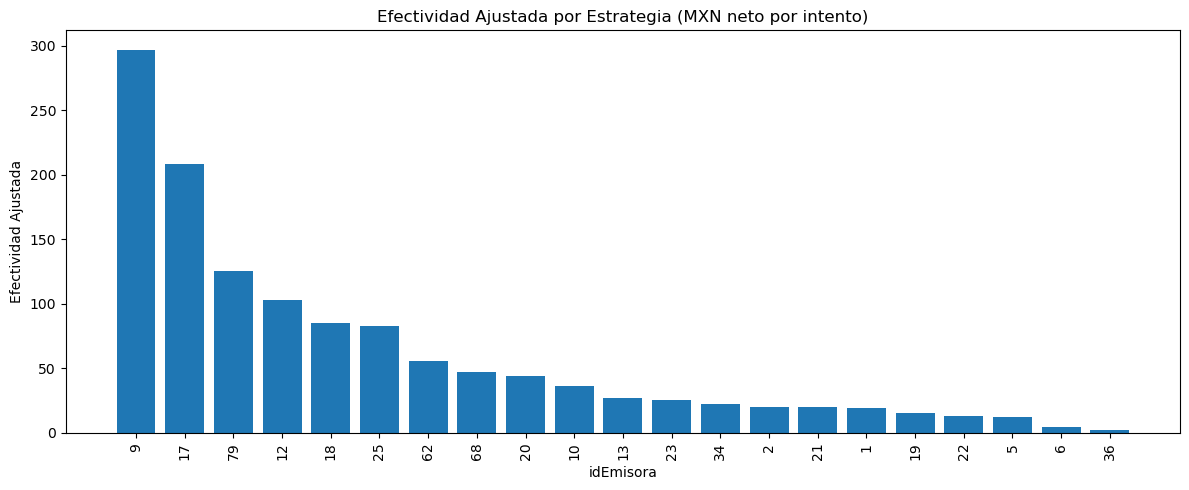

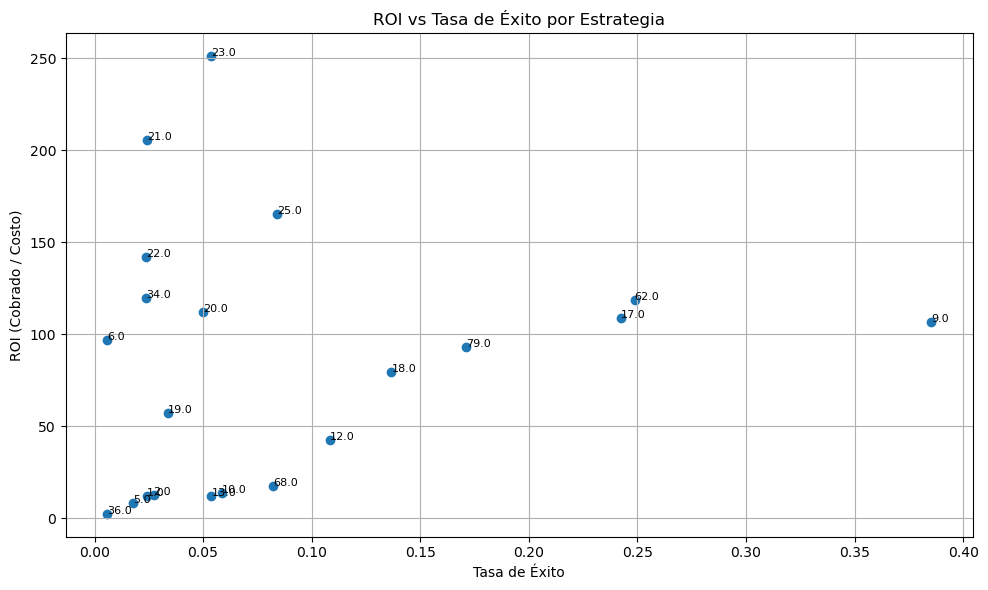

In [ ]:
# %%
# Gráfico: Efectividad ajustada
plt.figure(figsize=(12, 5))
plt.bar(estrategias_eval["idEmisora"].astype(str), estrategias_eval["efectividad_ajustada"])
plt.title("Efectividad Ajustada por Estrategia (MXN neto por intento)")
plt.xlabel("idEmisora")
plt.ylabel("Efectividad Ajustada")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Gráfico: ROI vs Tasa de Éxito
plt.figure(figsize=(10, 6))
plt.scatter(estrategias_eval["tasa_exito"], estrategias_eval["roi"])
for i, row in estrategias_eval.iterrows():
    plt.text(row["tasa_exito"], row["roi"], str(row["idEmisora"]), fontsize=8)
plt.xlabel("Tasa de Éxito")
plt.ylabel("ROI (Cobrado / Costo)")
plt.title("ROI vs Tasa de Éxito por Estrategia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico: ROI vs Tasa de Éxito solo valores no dominados por dominancia de pareto
estrategias_eval_no_dominadas = []
for i, row in estrategias_eval.iterrows():
    if not any((row["tasa_exito"] <= other["tasa_exito"] and row["roi"] <= other["roi"]) for other in estrategias_eval_no_dominadas):
        estrategias_eval_no_dominadas.append(row)
estrategias_eval_no_dominadas = pd.DataFrame(estrategias_eval_no_dominadas)
plt.figure(figsize=(10, 6))
plt.scatter(estrategias_eval_no_dominadas["tasa_exito"], estrategias_eval_no_dominadas["roi"])
for i, row in estrategias_eval_no_dominadas.iterrows():
    plt.text(row["tasa_exito"], row["roi"], str(row["idEmisora"]), fontsize=8)
plt.xlabel("Tasa de Éxito")
plt.ylabel("ROI (Cobrado / Costo)")
plt.title("ROI vs Tasa de Éxito por Estrategia (No Dominadas)")
plt.grid(True)
plt.tight_layout()
plt.show()



=== Classification Report (con class_weight='balanced') ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99   2875046
           1       0.52      0.34      0.41     87787

    accuracy                           0.97   2962833
   macro avg       0.75      0.66      0.70   2962833
weighted avg       0.97      0.97      0.97   2962833

AUC: 0.8547


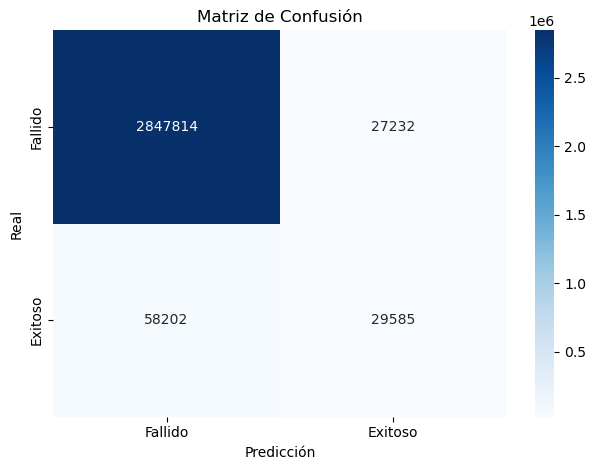

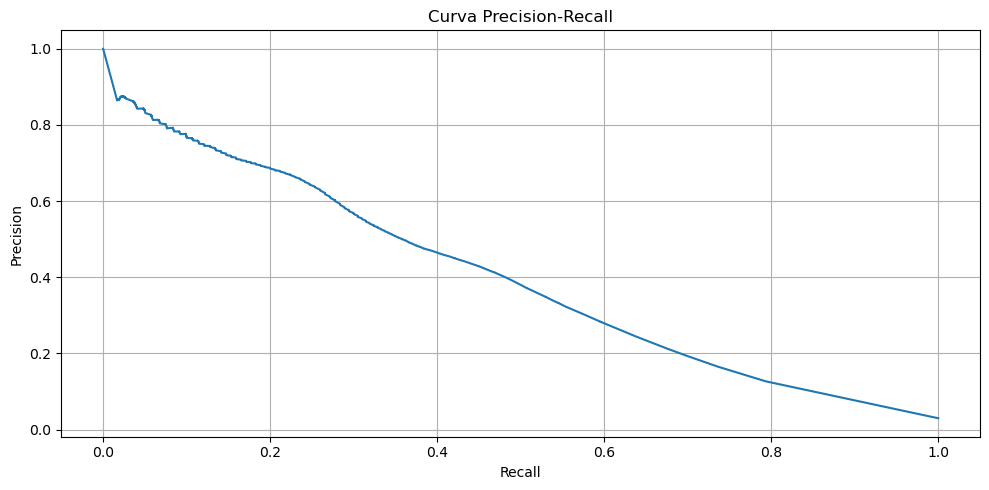

In [84]:
# %%
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Variables para el modelo, incluyendo información financiera
vars_modelo = [
    "idEmisora", "montoExigible", "montoCobrar",
    "num_intentos_previos", "num_exitos_previos", "es_segundo_intento",
    "costo", "cobraSoloExitoso"
]

# Preparar X e y
cobros10 = cobros
X = cobros10[vars_modelo]
y = cobros10["esExitoso"].astype(int)

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=["idEmisora", "cobraSoloExitoso"])

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo con ajuste por desbalance
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# === Evaluación ===
print("\n=== Classification Report (con class_weight='balanced') ===")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fallido", "Exitoso"], yticklabels=["Fallido", "Exitoso"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curva de precisión vs recall ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# Cargar la tabla de costos y flags de “cobraSoloExitoso”
import pandas as pd

cat = pd.read_csv("/Users/alvarobolanos/Desktop/DataThon/Reto Credifiel/ExtraccionDomiVersionFinal/CatEmisora.csv")[["idEmisora","costo","cobraSoloExitoso"]]
cat["cobraSoloExitoso"] = cat["cobraSoloExitoso"].astype(bool)

# Opcional: como diccionarios para acceso rápido
cost_by_estr = cat.set_index("idEmisora")["costo"].to_dict()
cobra_by_estr = cat.set_index("idEmisora")["cobraSoloExitoso"].to_dict()

# O bien mantener un DataFrame único:
estr_info = cat.copy()  # columnas: idEmisora, costo, cobraSoloExitoso

# ————————————————————————————————————————————————

def simular_estrategias_por_credito(cobros, clf, X_train_cols,
                                    umbral=0.05, n_creditos=500, random_state=42):
    """
    Simula para cada crédito de una muestra:
      A) Minimizar comisión (proba_exito ≥ umbral)
      B) Maximizar recaudación esperada
    Usando idEmisora → (costo, cobraSoloExitoso) desde `estr_info`/diccionarios.
    """
    import pandas as pd

    # 1) Último intento de cada crédito
    creditos = cobros["idCredito"].drop_duplicates()
    muestra  = creditos.sample(n_creditos, random_state=random_state)
    ultimos = (
        cobros[cobros["idCredito"].isin(muestra)]
        .sort_values(["idCredito","consecutivoCobro"])
        .groupby("idCredito").tail(1)
        .reset_index(drop=True)
    )

    resultados = []

    # 2) Recorre créditos
    for _, base in ultimos.iterrows():
        mejorA = None
        mejorB = None

        # 3) Recorre cada estrategia disponible en estr_info
        for _, e in estr_info.iterrows():
            idE  = e["idEmisora"]
            costo= e["costo"]
            cobra= e["cobraSoloExitoso"]

            # 3.1 ) Features
            fila = {
                "idEmisora":            idE,
                "montoExigible":        base["montoExigible"],
                "montoCobrar":          base["montoCobrar"],
                "num_intentos_previos": base["num_intentos_previos"],
                "num_exitos_previos":   base["num_exitos_previos"],
                "es_segundo_intento":   base["es_segundo_intento"]
            }
            dfX = pd.DataFrame([fila])
            dfX_enc = pd.get_dummies(dfX, columns=["idEmisora"], drop_first=False)
            dfX_enc = dfX_enc.reindex(columns=X_train_cols, fill_value=0)

            # 3.2 ) Predecir
            proba   = clf.predict_proba(dfX_enc)[0,1]
            exp_rec = proba * base["montoCobrar"]

            # 4A) Escenario A: costo mínimo de los que superan el umbral
            if proba >= umbral and base["respuestaCategoria"] != "cuenta_invalida":
                if mejorA is None or costo < mejorA[0]:
                    mejorA = (costo, {
                        "idCredito":        base["idCredito"],
                        "consecutivoCobro": base["consecutivoCobro"],
                        "idBanco":          base["idBanco"],
                        "idEmisora":        idE,
                        "proba_exito":      proba,
                        "costoTransaccion": costo,
                        "expected_recaudo": exp_rec,
                        "escenario":        "Minimizar Comisión"
                    })

            # 4B) Escenario B: maximizar recaudación esperada
            if mejorB is None or exp_rec > mejorB[0]:
                mejorB = (exp_rec, {
                    "idCredito":        base["idCredito"],
                    "consecutivoCobro": base["consecutivoCobro"],
                    "idBanco":          base["idBanco"],
                    "idEmisora":        idE,
                    "proba_exito":      proba,
                    "costoTransaccion": costo,
                    "expected_recaudo": exp_rec,
                    "escenario":        "Maximizar Recaudación"
                })

        # 5) Almacenar
        if mejorA:
            resultados.append(mejorA[1])
        if mejorB:
            resultados.append(mejorB[1])

    # 6) Devolver DataFrame final
    return pd.DataFrame(resultados)


In [86]:
# Tomar 10% de los valores de cobros aleatoriamente
cobros10 = cobros.sample(frac=0.01, random_state=42)
resultados_simulacion = simular_estrategias_por_credito(
    cobros10, clf, X_train_cols=X_train.columns,
    umbral=0.05, n_creditos=500, random_state=42
)
# Mostrar resultados de la simulación
print(resultados_simulacion.head())

   idCredito  consecutivoCobro  idBanco  idEmisora  proba_exito  \
0      70754          32881151        2          9         0.09   
1      70754          32881151        2          9         0.09   
2     122087          32084430        2          5         0.02   
3     122972          38397877       21         23         0.07   
4     122972          38397877       21         17         0.31   

   costoTransaccion  expected_recaudo              escenario  
0              2.82           30.3480     Minimizar Comisión  
1              2.82           30.3480  Maximizar Recaudación  
2              1.75           13.1458  Maximizar Recaudación  
3              1.91           75.2563     Minimizar Comisión  
4              8.00          333.2779  Maximizar Recaudación  


In [87]:
# Contar la cantidad de idEmisora
print(resultados_simulacion["idEmisora"].value_counts())

idEmisora
1     183
17    139
2     127
62    105
13     87
36     48
9      47
79     42
5      38
3      38
10     34
12     26
23     20
68     18
25      6
6       6
22      5
21      3
18      2
20      1
34      1
Name: count, dtype: int64
